# The Best Times to Post to Various Subreddits

A few weeks ago Redditor [/u/Stuck_In_the_Matrix](https://www.reddit.com/user/Stuck_In_the_Matrix) released the [full corpus of reddit submissions](https://www.reddit.com/r/datasets/comments/3mg812/full_reddit_submission_corpus_now_available_2006/) from January 2006 to August 31, 2015. Just a few days later [/u/fhoffa](https://www.reddit.com/user/fhoffa) made it [available via Google Big Query](https://www.reddit.com/r/bigquery/comments/3mv82i/dataset_reddits_full_post_history_shared_on/).

Max Wolf [wrote a tutorial](http://minimaxir.com/2015/10/reddit-bigquery/) on how to analyze this dataset providing some interesting examples, one of them looking at the best time to post to reddit, considering only submissions that reached more than 3000 posts. Felipe also [took a stab at this](https://www.reddit.com/r/dataisbeautiful/comments/3nkwwa/the_best_time_to_post_to_reddit_east_coast_early/) broken down by subreddits.

Both charts indicate, that the time of submission is a big factor for success. Max' chart doesn't take differences between subreddits into account and Felipe's chart doesn't account for the influence of weekdays though. So let's break down the time of submission by weekday and hour for several subreddits. Please note that in contrast to Max and Felipe I look at posts with more than 1000 points from all years and use Coordinated Universal Time (UTC) instead of Eastern Standard Time (EST).

## Biqguery

I ran the following query to get the data via Google's BigQuery interface.

    SELECT subreddit, dayofweek, hourofday, num_with_min_score, total
    FROM (
      SELECT
        DAYOFWEEK(created_utc) as dayofweek,
        HOUR(created_utc) as hourofday,
        SUM(score >= 1000) as num_with_min_score,
        SUM(num_with_min_score) OVER(PARTITION BY subreddit) total,
        subreddit,
      FROM [fh-bigquery:reddit_posts.full_corpus_201509]
      GROUP BY subreddit, dayofweek, hourofday
      ORDER BY subreddit, dayofweek, hourofday
    )
    WHERE total>100
    ORDER BY total DESC, dayofweek, hourofday

This returns the number of posts that reached more than 1000 points broken down by subreddit, weekday and hour of the day, for all subreddits that have at least 100 submissions with more than 1000 points. Since the resulting dataset was too large to download directly, I had to create a table from it first and export it to a Google cloud storage bucket, before I could download it to my computer.

## Setup

Next we'll load the necessary libraries, set some global display variables and read the downloaded CSV file ino a [pandas DataFrame](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.html) and show the first few lines.

In [168]:
%matplotlib inline
%load_ext signature

import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import helpers

# Set style and meta info.
mpl.style.use('ramiro')
mpl.rcParams['axes.grid'] = False

weekdays_short = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
chartinfo = '''Based on all publicly available reddit submissions from January 2006 to August 31, 2015. 
Author: Ramiro Gómez - ramiro.org • Data: /u/Stuck_In_the_Matrix & /u/fhoffa - reddit.com'''
infosize = 12

df = pd.read_csv('data/reddit/reddit-top-posts-by-subreddit-weekday-hour.csv')
df.head()

The signature extension is already loaded. To reload it, use:
  %reload_ext signature


,subreddit,dayofweek,hourofday,num_with_min_score,total
0,funny,1,0,909,139737
1,funny,1,1,898,139737
2,funny,1,2,841,139737
3,funny,1,3,736,139737
4,funny,1,4,568,139737


## Plotting function

To avoid repeating code, I put the plot creation into the function below. If called with a subreddit it filters the data accordingly, then groups by weekday and hour. This grouped data is then unstacked to yield the data structure needed for the call to [imshow](http://matplotlib.org/api/pyplot_api.html#matplotlib.pyplot.imshow). The remaining code is for setting annotations, labels, ticks and the color legend.

In [166]:
def plot_post_times(subreddit=None):
    df_plot = df.copy()
    title = 'Number of reddit submissions that reached ≥ 1000 points by time of submission'
    
    if subreddit:
        df_plot = df[df['subreddit'] == subreddit.lower()]
        title = 'Number of submissions to /r/{} that reached ≥ 1000 points by time of submission'.format(subreddit)
    
    grouped = df_plot.groupby(['dayofweek', 'hourofday'])['num_with_min_score'].sum()
    if grouped.empty:
        print('Empty series after grouping.')
        return
    
    image = grouped.unstack()

    fig, ax = plt.subplots(figsize=(14, 5))
    cmap = plt.cm.Greens
    img = ax.imshow(image, cmap=cmap, interpolation='nearest')
    
    # Annotations, labels, and axes ticks.
    ax.set_title(title, y=1.08, fontsize=16)
    ax.annotate(chartinfo, xy=(0, -1.35), xycoords='axes fraction', fontsize=infosize)
    ax.set_xlabel('Hour of reddit submission (UTC)', fontsize=infosize)
    ax.set_ylabel('Weekday of reddit submission', fontsize=infosize)
    plt.xticks(range(24))
    plt.yticks(range(7), weekdays_short)

    # Draw color legend.
    values = grouped.values
    bins = np.linspace(values.min(), values.max(), 5)
    plt.colorbar(img, shrink=.6, ticks=bins)

    plt.savefig('img/' + helpers.slug(title), bbox_inches='tight')

The signature extension is already loaded. To reload it, use:
  %reload_ext signature


## All subreddits with at least 100 submissions that reached 1000 points

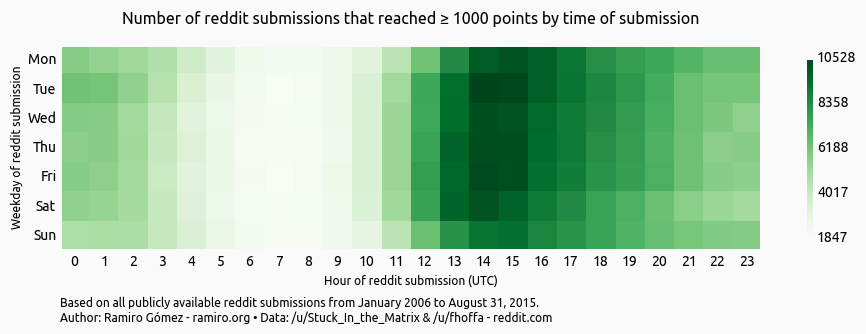

In [170]:
plot_post_times()

## Selected subreddits

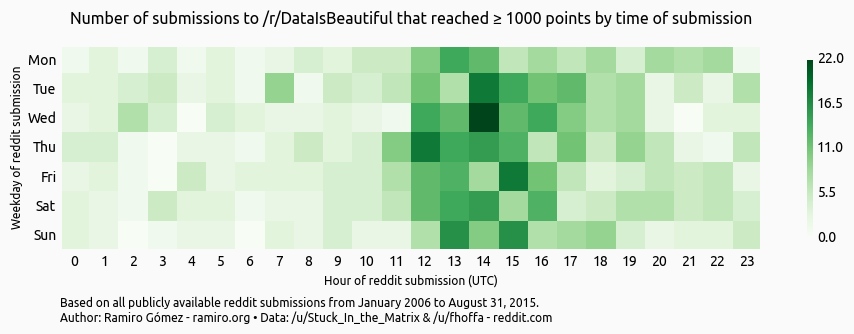

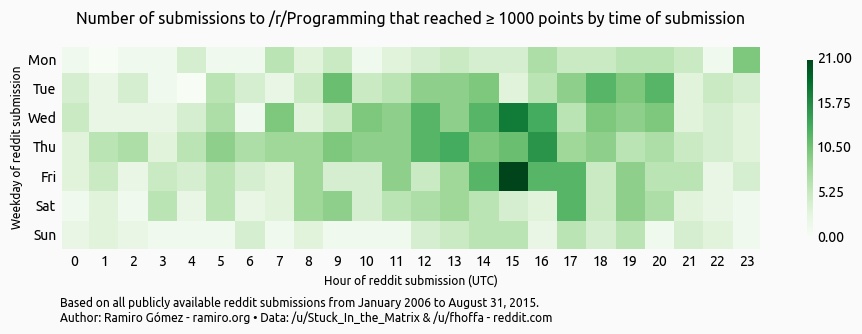

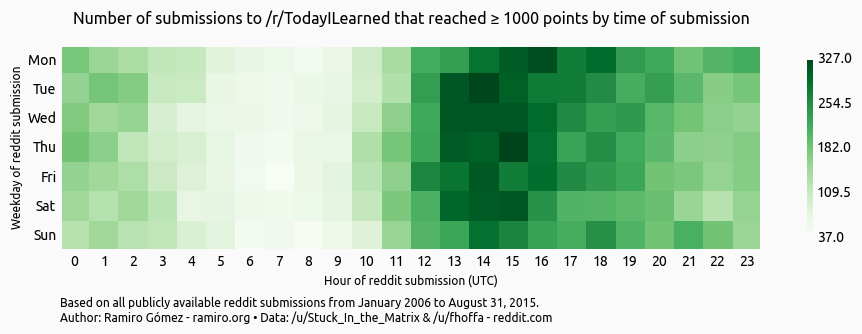

In [172]:
plot_post_times('DataIsBeautiful')
plot_post_times('Programming')
plot_post_times('TodayILearned')

In [165]:
df.groupby('subreddit').sum().sort('num_with_min_score', ascending=False)

,dayofweek,hourofday,num_with_min_score,total
subreddit,,,,
funny,672,1932,139737,23475816
AdviceAnimals,672,1932,73386,12328848
pics,672,1932,68370,11486160
aww,672,1932,37886,6364848
gaming,672,1932,36017,6050856
WTF,672,1932,35426,5951568
todayilearned,672,1932,28065,4714920
gonewild,672,1932,21460,3605280
videos,672,1932,20374,3422832


In [169]:
%signature